In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cityseer.metrics import layers
from cityseer.tools import graphs, io


In [3]:
streets_gpd = gpd.read_file("data/madrid_streets/street_network.gpkg")
streets_gpd = streets_gpd.explode(reset_index=True)
G = io.nx_from_generic_geopandas(streets_gpd)
G = graphs.nx_decompose(G, 50)
G_dual = graphs.nx_to_dual(G)
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(G_dual)

100%|██████████| 47155/47155 [00:03<00:00, 14086.64it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
100%|██████████| 47129/47129 [00:00<00:00, 272076.10it/s]
INFO:cityseer.tools.graphs:Decomposing graph to maximum edge lengths of 50.
100%|██████████| 47129/47129 [00:07<00:00, 6201.84it/s]
INFO:cityseer.tools.graphs:Converting graph to dual.
INFO:cityseer.tools.graphs:Preparing dual nodes
100%|██████████| 137778/137778 [00:01<00:00, 79032.88it/s] 
INFO:cityseer.tools.graphs:Preparing dual edges (splitting and welding geoms)
100%|██████████| 137778/137778 [00:37<00:00, 3709.06it/s]
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|██████████| 137778/137778 [00:17<00:00, 7870.28it/s] 


In [9]:
bldgs_gpd = gpd.read_file("data/madrid_buildings/madrid_bldgs.gpkg")
bldgs_gpd.head()

,mean_height,area,perimeter,compactness,orientation,volume,floor_area_ratio,form_factor,corners,shape_index,fractal_dimension,geometry
0,NaN,187.418714,58.669276,0.491102,40.235999,NaN,NaN,NaN,4,0.700787,1.026350,"POLYGON ((448688.642 4492911, 448678.351 44928..."
1,7.0,39.082821,26.992208,0.472874,10.252128,273.579749,78.165643,5.410857,4,0.687658,1.041691,"POLYGON ((440862.665 4482604.017, 440862.64 44..."
2,7.0,39.373412,27.050303,0.475086,10.252128,275.613883,78.746824,5.400665,4,0.689265,1.040760,"POLYGON ((440862.681 4482608.269, 440862.665 4..."
3,7.5,37.933979,26.739878,0.464266,10.252129,284.504846,75.867959,5.513124,4,0.681371,1.045072,"POLYGON ((440862.705 4482612.365, 440862.681 4..."
4,7.0,39.013701,26.972641,0.472468,10.183618,273.095907,78.027402,5.412350,4,0.687363,1.041798,"POLYGON ((440880.29 4482607.963, 440880.274 44..."


In [10]:
# compute pub accessibility
distances = [100, 200, 400, 800]
nodes_gdf, bldgs_gpd = layers.compute_stats(
    bldgs_gpd,
    stats_column_labels=[
        "area",
        "perimeter",
        "compactness",
        "orientation",
        "shape_index",
    ],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=distances,
)

INFO:cityseer.metrics.layers:Computing statistics.
INFO:cityseer.metrics.layers:Assigning data to network.
100%|██████████| 137778/137778 [03:52<00:00, 591.43it/s]
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 100m, Beta: 0.04, Walking Time: 1.25 minutes.
INFO:cityseer.config:Distance: 200m, Beta: 0.02, Walking Time: 2.5 minutes.
INFO:cityseer.config:Distance: 400m, Beta: 0.01, Walking Time: 5.0 minutes.
INFO:cityseer.config:Distance: 800m, Beta: 0.005, Walking Time: 10.0 minutes.


In [7]:
nodes_gdf.columns

Index(['ns_node_idx', 'x', 'y', 'live', 'weight', 'primal_edge',
       'primal_edge_node_a', 'primal_edge_node_b', 'primal_edge_idx',
       'dual_node',
       ...
       'cc_shape_index_sum_800_nw', 'cc_shape_index_sum_800_wt',
       'cc_shape_index_mean_800_nw', 'cc_shape_index_mean_800_wt',
       'cc_shape_index_count_800_nw', 'cc_shape_index_count_800_wt',
       'cc_shape_index_var_800_nw', 'cc_shape_index_var_800_wt',
       'cc_shape_index_max_800', 'cc_shape_index_min_800'],
      dtype='object', length=210)

<Axes: xlabel='cc_area_mean_400_wt', ylabel='Count'>

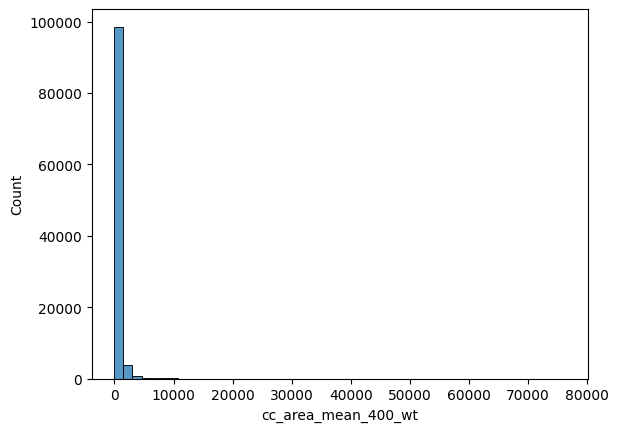

In [13]:
import seaborn as sns

sns.histplot(
    data=nodes_gdf,
    x="cc_area_mean_400_wt",
    bins=50,
)

In [ ]:
nodes_gdf["cc_area_mean_400_wt"].describe()

count    104025.000000
mean        583.678223
std        1128.738403
min           0.376312
25%         227.186035
50%         355.914185
75%         608.387695
max       76338.296875
Name: cc_area_mean_400_wt, dtype: float64

(np.float64(438500.0),
 np.float64(442000.0),
 np.float64(4472500.0),
 np.float64(4476000.0))

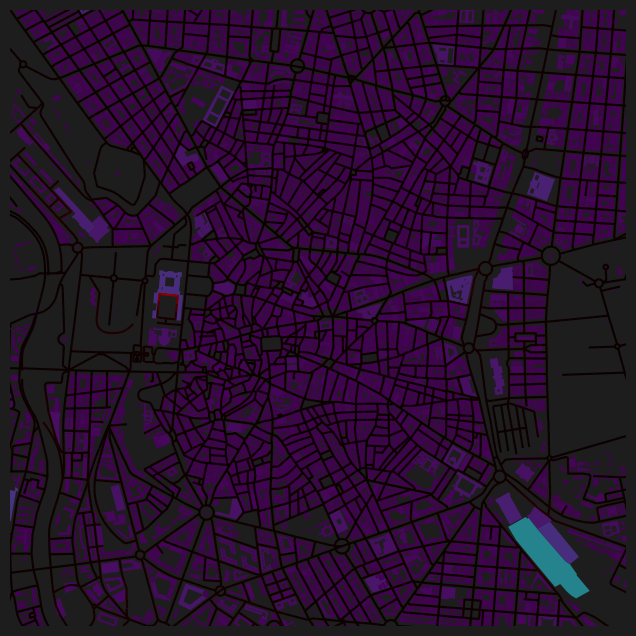

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_area_mean_400_wt",
    cmap="hot",
    legend=False,
    # norm=colors.LogNorm(),  # Apply log normalization
    ax=ax,
)
bldgs_gpd.plot(
    column="area",
    cmap="viridis",
    legend=False,
    # norm=colors.LogNorm(),  # Apply log normalization
    ax=ax,
)
ax.set_xlim(438500, 438500 + 3500)
ax.set_ylim(4472500, 4472500 + 3500)
ax.axis(False)
